In [561]:
import pygad 
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, skew
import matplotlib.pyplot as plt
from numba import int32, float32, float64, jit, types, typeof   # import the types
from numba.experimental import jitclass

In [1147]:
def expected_returns(period):
    return pd.Series({
		'ACWI': 0.07/period,
		'^TBSP': 0.035/period,
		'XAUPLN': 0.05/period,
		'MWIG40': 0.065/period,
		'IHYU.L': 0.038/period,
		'PLOPLN3M': 0.03/period,
		'edo': 0.033/period
})

""" cov = np.array([[0.001265,	0.000042],
            	[0.000042,	0.000164]]) """
#acwi edo
cov = np.array([[0.003211,	0.0],
            	[0.0,	0.000011]])
cov_y = cov * 12

In [1248]:
assets = ['ACWI', 'edo']
means = expected_returns(1)[assets]
number_of_scenarios = 1501
T = 20
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov_y, T))

sim_returns = np.array(sim_returns)
sim_returns.shape

(1501, 20, 2)

In [1149]:
means = sim_returns.mean(1)

result = pd.DataFrame({},index=['mean','0.25','0.5','0.75'])
result.loc['mean','mean'] = means[0].mean()
result.loc['mean','mean_ann'] = means[0].mean() *12
result.loc['mean','std'] = means[0].std()
result.loc['mean','skewsness'] = skew(means[0])

sorted = np.sort(means,0)
result.loc['0.25','mean'] = sorted[len(means)//4*1].mean()
result.loc['0.25','mean_ann'] = sorted[len(means)//4*1].mean() *12
result.loc['0.25','std'] = sorted[len(means)//4*1].std() 
result.loc['0.5','mean'] = sorted[len(means)//4*2].mean()
result.loc['0.5','mean_ann'] = sorted[len(means)//4*2].mean() *12
result.loc['0.5','std'] = sorted[len(means)//4*2].std() 
result.loc['0.75','mean'] = sorted[len(means)//4*3].mean()
result.loc['0.75','mean_ann'] = sorted[len(means)//4*3].mean() *12
result.loc['0.75','std'] = sorted[len(means)//4*3].std() 
result


,mean,mean_ann,std,skewsness
mean,0.090171,1.082050,0.060099,-3.746022e-16
0.25,0.033329,0.399952,0.002389,NaN
0.5,0.051556,0.618675,0.018683,NaN
0.75,0.069293,0.831511,0.034169,NaN


In [1150]:
def fanchart(hist,percentiles):
    length = 19
    x = np.linspace(0,length+1,length+1)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[4], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[3], color='blue', alpha=0.2)
    ax.plot(percentiles[2],color='blue')

ValueError: operands could not be broadcast together with shapes (20,) (10,) 

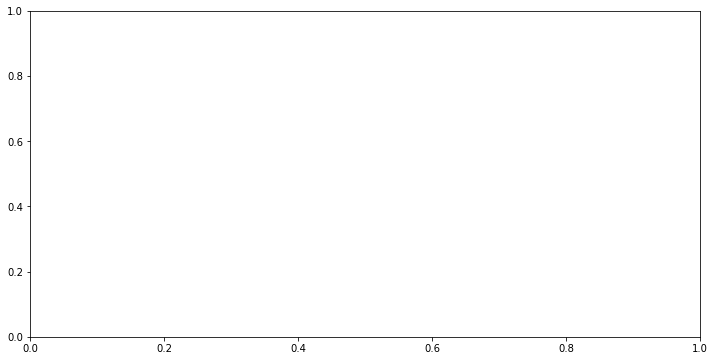

In [1166]:
perc = np.percentile(sim_returns[:,:,0],[5,25,50,75,95],axis=0)
fanchart(None,perc)

In [1188]:
spec = [
    ('capital', float64),
    ('returns', float64[:,:,:]),
    ('strategy', float64[:,:]),
    ('inflows', int32[:])
]
#@jitclass(spec)
class Simulation():
    def __init__(self, initial_value, inflows, returns, strategy) -> None:
        self.capital = initial_value
        self.returns = returns
        self.strategy = strategy 
        self.inflows = inflows
        
    def step(self, current_value,inflow,weights,returns):
        current_assets_value = np.expand_dims(current_value,axis=0).T * weights + inflow
        next_assets_value =  np.round(current_assets_value * (1+returns),2)
        return next_assets_value.sum(1)
         
    def run(self, T):
        for t in range(T):
            self.capital = self.step(self.capital,self.inflows[t],self.strategy[t],self.returns[:,t])


In [993]:
portfolios = [[0.0,1.0],
             [0.1,0.9],
             [0.2,0.8],
             [0.3,0.7],
             [0.4,0.6],
             [0.5,0.5],
             [0.6,0.4],
             [0.7,0.3],
             [0.8,0.2],
             [0.9,0.1],
             [1.0,0.0]]

In [1241]:
T = 20
capital = np.full(number_of_scenarios,100)
inflows = np.full(T,0)

l = np.arange(T,0,-1)
risk = 40

glide_paths = {}
perc = np.zeros((l.shape[0]+1,len(portfolios)))

for t in l:
    
    for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        #perc.append(np.percentile(simulator.capital,risk))
        perc[t,portfolio] = np.percentile(simulator.capital,risk)
    glide_paths[t] = np.argmax(perc[t])

glide = list(glide_paths.values())
glide

    #TODO for portfolio in range(len(portfolios)) na range(glide_paths[t-1])

[7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 6, 7, 5, 6, 6, 3, 3, 3, 1]

In [931]:
T=15
risk = 0.25
perc = []
for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))

In [243]:
simulator = Simulation(100,np.full(T,0), sim_returns,glide)
simulator.run(T)
#np.percentile(simulator.capital,risk)
end_capital = simulator.capital

In [1218]:
r = 0.4
T = 15
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)
    

In [1219]:
fitness(None,glide,None)

166.29

In [1220]:
def initial_population(T,number_porfolios,solutions):
    population = np.zeros((solutions,T))
    population[11:,0] = np.random.randint(0,number_porfolios+1, solutions-11)
    for t in range(1,T):
        population[11:,t] = np.random.randint(0,population[11:,t-1]+1, solutions-11)
    for p in range(0,11):
        population[p,:] = p
    return population

In [1221]:
def init2(portfolios,T, population_size):
    population = np.zeros((population_size, T))
    random_size = population_size-len(portfolios) 
    population[0:random_size] = np.random.choice(gen_space,(random_size,T))
    for p in range(len(portfolios)):
        population[random_size+p,:] = p
    return np.flip(np.sort(population,1),1)

In [1222]:
def init3(portfolios,T, population_size):
    population = np.zeros((len(portfolios), T))
    for p in range(len(portfolios)):
        population[p,:] = p  
    ranges = [(3,11),(5,11),(7,21),(9,21),(11,21)]
    for r in ranges:
        rp = np.random.randint(0,r[0],(r[1],T))
        population = np.append(population, rp, axis=0)
    return np.flip(np.sort(population,1),1)


In [1223]:
def isDescending(arr):
    diff = np.diff(arr)
    return np.all(diff <= 0)

def m_crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        random_split_point = np.random.choice(range(1,offspring_size[1]))

        result = parent1.copy()
        result[random_split_point:] = parent2[random_split_point:]
        if isDescending(result) != True:
            result = parent2.copy()
            result[random_split_point:] = parent1[random_split_point:]
           
        offspring.append(result)      

        idx += 1

    return np.array(offspring)

In [1224]:
def applyMutation(offset, mutation_idx, mutation_value):
    result = offset
    newValue = offset[mutation_idx] + mutation_value
    result[mutation_idx] = newValue
    if(mutation_value> 0):
        diff = offset[0:mutation_idx] - newValue
        result[0:mutation_idx] = np.where(diff < 0, offset[0:mutation_idx] - diff , offset[0:mutation_idx])
    else:
        diff = offset[mutation_idx+1:] - newValue
        result[mutation_idx+1:] = np.where(diff > 0, offset[mutation_idx+1:] - diff , offset[mutation_idx+1:])
    return result

def mutation_func(offspring, ga_instance):
    
    for chromosome_idx in range(offspring.shape[0]):
        if (np.random.random() <= ga_instance.mutation_probability):  
            random_gene_idx = np.random.choice(range(offspring.shape[1]))
            mutated_value = np.random.randint(ga_instance.random_mutation_min_val,ga_instance.random_mutation_max_val)
            result = applyMutation(offspring[chromosome_idx],random_gene_idx,mutated_value)
            result = np.where(result > np.max(ga_instance.gene_space), np.max(ga_instance.gene_space), result)
            result = np.where(result < np.min(ga_instance.gene_space), np.min(ga_instance.gene_space), result)
            offspring[chromosome_idx] = result
            
    return offspring

#TODO zabezpieczyc mutation <= max porfolio

In [1225]:
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
offspring = np.array([5,4,3,0,0])
result = applyMutation(offspring,3,1)
result = np.where(result > np.max(gen_space), np.max(gen_space), result)
result = np.where(result < np.min(gen_space), np.min(gen_space), result)
result

array([5, 4, 3, 1, 0])

In [1277]:
r = 0.2
T = 20
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,10),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)

In [1278]:
initial_pop = init2(portfolios,T,100) #initial_population(T,10,100)

In [1279]:
print(np.count_nonzero(initial_pop == 0,axis=0))
print(np.count_nonzero(initial_pop == 1,axis=0))
print(np.count_nonzero(initial_pop == 2,axis=0))
print(np.count_nonzero(initial_pop == 3,axis=0))
print(np.count_nonzero(initial_pop == 4,axis=0))
print(np.count_nonzero(initial_pop == 5,axis=0))
print(np.count_nonzero(initial_pop == 6,axis=0))
print(np.count_nonzero(initial_pop == 7,axis=0))
print(np.count_nonzero(initial_pop == 8,axis=0))
print(np.count_nonzero(initial_pop == 9,axis=0))
print(np.count_nonzero(initial_pop == 10,axis=0))

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  4 10 31 53 79]
[ 1  1  1  1  1  1  1  1  1  1  2  3  5  7 13 28 35 34 25 12]
[ 1  1  1  1  1  1  1  1  1  2  2  7 13 23 33 31 28 22 14  1]
[ 1  1  1  1  1  1  2  2  4  7 15 19 25 31 25 23 16  6  1  1]
[ 1  1  1  1  1  1  1  3  6 19 29 32 34 23 16  6  3  1  1  1]
[ 1  1  1  1  2  6 15 24 34 26 27 22 12  7  5  2  2  1  1  1]
[ 1  1  2  3  6 19 22 27 24 29 14 10  5  4  2  2  2  1  1  1]
[ 1  1  3  8 33 30 33 29 22  9  6  3  2  1  1  1  1  1  1  1]
[ 3 11 21 40 32 29 18  9  5  4  2  1  1  1  1  1  1  1  1  1]
[17 32 44 38 21 10  5  2  1  1  1  1  1  1  1  1  1  1  1  1]
[72 49 24  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [1280]:
sol_per_pop = 100
num_genes = T
num_parents_mating = 20
keep_parents = 1
gene_type= int
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
parent_selection_type = 'tournament'
crossover_type = "single_point"
num_generations= 200
fitness_function = fitness
mutation_type = mutation_func #"random"
#mutation_percent_genes = 10
random_mutation_min_val=-2.0
random_mutation_max_val=2.0
mutation_probability=0.4
crossover_probability=0.6
crossover_func=m_crossover_func
stop_criteria = "saturate_200"

In [1281]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       #sol_per_pop=sol_per_pop,
                       initial_population = initial_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gen_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       #crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       #mutation_percent_genes=mutation_percent_genes,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       mutation_probability=mutation_probability,
                       crossover_probability=crossover_probability,
                       crossover_type= crossover_func,
                       stop_criteria = stop_criteria,
                       save_solutions=True
                       )

In [1282]:
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [1283]:
print(solution)
print(solution_fitness)

[4 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
756.86


In [1233]:
(solution_fitness/100)**(1/T)-1

0.09684926129263238

In [1081]:
for t in range(0,len(solution)):
    print('{0}: {1}'.format(t, + solution[t]))

0: 9
1: 9
2: 9
3: 8
4: 8
5: 8
6: 8
7: 7
8: 7
9: 7
10: 7
11: 7
12: 7
13: 3
14: 2


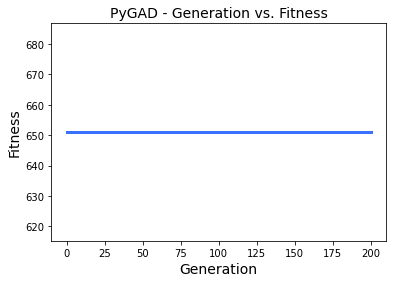

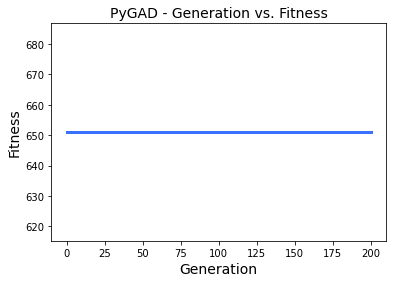

In [1269]:
ga_instance.plot_fitness()

[ 0  0  0  7  3  0  8  6  0  5  4  2  8  4  1 10  6  8  9  3  9 10  8  9
  9  3  4  7  1  5  3  3  7  5  1 10 10  9  8  4  4  4  5  9  7  6  5  5
  6  8  5  1  3  9  2  4  5  2  0  7]
129.62

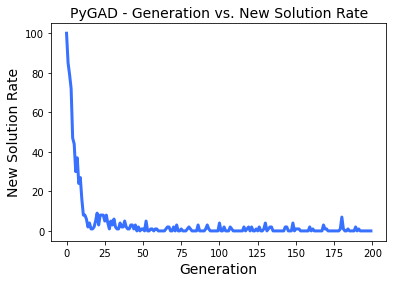

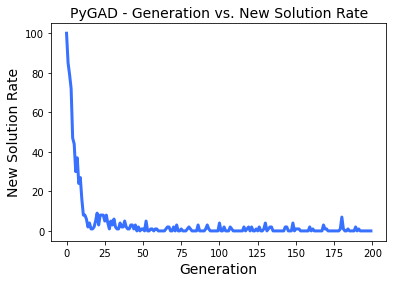

In [1268]:
ga_instance.plot_new_solution_rate()

In [957]:
#[6, 3, 3, 3, 2]
fitness(None,[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0],0)


167.24

In [ ]:
from unittest.mock import patch

def mock_rand(range):
        return 0


parents = np.array([[4,3,3,2,2],
                     [7,6,5,2,1]])

result = None

""" with patch('numpy.random.choice',mock_rand):
    result = crossover_func(parents, (1,5), None) """

crossover_func(parents, (1,5), None)
#result

array([[4, 3, 3, 2, 1]])

In [ ]:
arr = [4,3,3,3,3]
arr[:0]

[]

In [ ]:
offspring = np.array([[10,10,8,8,6,6]])
mutation_func(offspring, ga_instance)

array([[10, 10,  8,  8,  6,  6]])

In [1267]:
import random
probs = np.random.random(size=20)
indices = np.where(probs <= 0.6)[0]
random.sample(list(set(indices)), 2)

[17, 9]